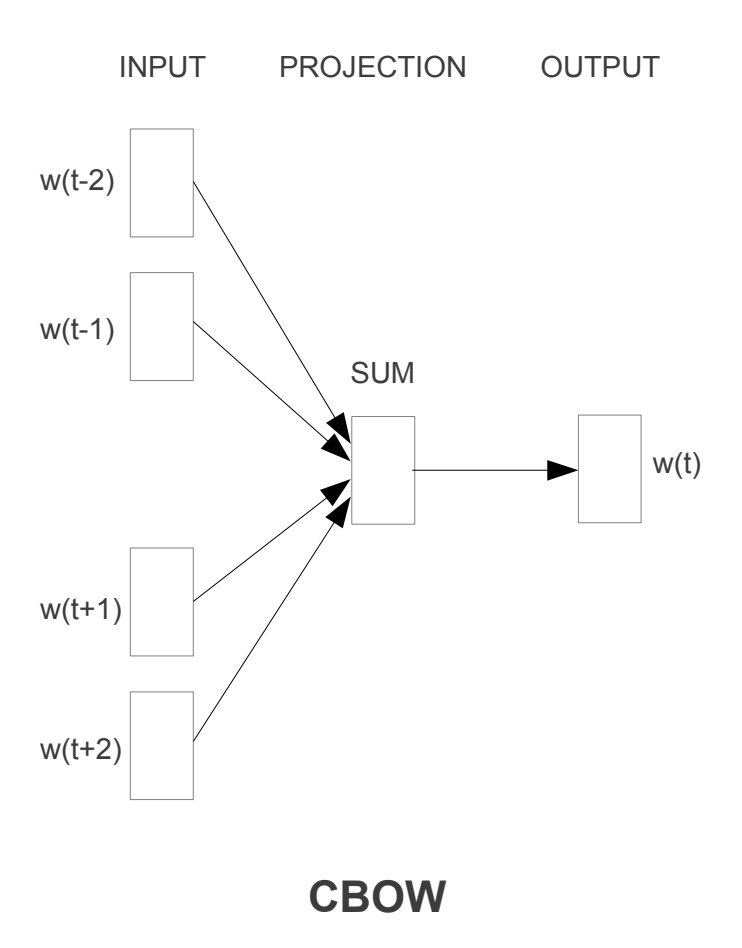

In [5]:
from IPython.display import Image
Image("../imgs/CBOW.png")

# 추론 기반 기법과 신경망


## 통계 기반 기법의 문제점

통계 기반 기법의 문제점은 대규모 말뭉치를 다룰 때 $O(n^3)$의 비용이 든다는 점

- `통계 기반 기법` : 학습 데이터를 한꺼번에 처리 (배치 학습)
- `추론 기반 기법`: 학습 데이터의 일부를 사용하여 순차적으로 학습(미니배치 학습)

미니배치 학습은 계산량이 큰 작업을 처리할 때 효율적. 데이터를 작게 나눠 학습하기 때문에 연산 가능. 또한 병렬 계산도 가능하게 하여 학습 속도 또한 높일 수 있다.

## 추론 기반 기법 개요
```
you ? goodbye and I say hello.
```
문장에서 ?을 추론하는 작업. 모델은 이러한 추론 문제를 반복해서 풀면서 **단어의 출현 패턴을 학습**한다.

## 신경망에서의 단어 처리

신경망을 이용해 단어를 처리하기 위해서는 단어를 **고정 길이의 벡터**로 변환해야 한다.

대표적인 방법이 `원핫 표현 (one-hot encoding)`

입력층의 각 뉴런이 각 단어에 대응됨

In [2]:
# 완전연결계층에 의한 원핫 인코딩 형식의 단어 변환
# 7 X 3 계층, bias는 생략됨
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0]) # 원 핫 입력
W = np.random.randn(7,3) # 가중치
h = np.matmul(c,W) # 중간 노드
print(h)

[-0.94156747  0.46990781  1.42877554]


원핫 표현의 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터.

즉, c와 W의 행렬 곱은 **가중치의 행벡터 하나**를 뽑아낸 것과 같다.

때문에 비효율적인 계산 방식. (4장에서 개선)

# 단순한 word2vec

## CBOW 모델의 추론 처리

CBOW <sup>continuous bag-of-words<sup>
    
CBOW 모델은 **맥락으로부터 타깃(target)을 추측**하는 용도의 신경망이다. 

- 타깃 : 중앙 단어
- 맥락 : 중앙 단어의 주변 단어들

<u>맥락이 입력이고 타깃이 출력이다</u>

<img src="../imgs/CBOW.png" width="300" align='left'>

위 그림을 보면 입력층이 4개 있고, 은닉층을 거쳐 출력층에 도달한다. 

4개의 입력층에서 은닉층으로의 변환은 완전연결계층 $W_{in}$ 이 처리한다. 

그리고 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층 $W_{out}$이 처리한다. 

위 그림에서 입력층이 4개인 이유는 맥락으로 고려할 단어를 4개로 정했기 때문. 

---

- 입력층 : 맥락에 포함시킬 단어가 N개라면 입력층도 N개이다.
<br></br><br></br>
- 은닉층 : 입력층의 여러개를 평균낸 값
<br></br><br></br>
- 출력층 : 뉴런의 개수 총 7개. 뉴런 하나하나가 각각의 단어에 대응된다. **출력층 뉴런은 각 단어의 '점수'를 뜻하며 값이 높을수록 대응 단어의 출현 확률도 높아진다.** 여기서 점수란 확률로 해석되기 전 값이고, 이 점수에 소프트맥수를 적용해서 확률을 얻을 수 있다.

---

입력층에서 은닉층으로의 변환을 완전연결계층 (가중치 $W_{in}$)이 처리한다. 

이때, 완전연결계층의 **가중치 $W_{in}$은 $7X3$ 행렬이며, 이 가중치의 각 행이 해당 단어의 분산 표현!**

        you - 0 0 0
        say - 0 0 0
    goodbye - 0 0 0
        and - 0 0 0
          I - 0 0 0
      hello - 0 0 0
          . - 0 0 0 
          
따라서 **학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 갱신**될 것

In [9]:
## CBOW 모델의 추론 처리

import sys
sys.path.append('..')
import numpy as np
from common_wj.layers import MatMul

# 샘플 맥락 데이터 
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)

in_layer0



ModuleNotFoundError: No module named 'common_wj.layers'

In [10]:
!ls ../

README.md ch01      ch02      ch03      common_wj dataset   imgs
